# Graph extraction

#### Extract vertices example

По описанию на естественном языке должны извлекаться вершины.

In [ ]:
# !git clone https://github.com/intsystems/graphical-model-generation.git -q
# !cp /content/graphical-model-generation/code/*.py .
%pip install openai langchain langchain_openai

In [ ]:
import os
# from google.colab import userdata
from openai import OpenAI, AsyncOpenAI
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)
from langchain.prompts import PromptTemplate, HumanMessagePromptTemplate
from openai import OpenAI, AsyncOpenAI
from typing import List
from pydantic import BaseModel
import json
import sys
sys.path.insert(0, "/home/ernest/Desktop/graphical-model-generation/code")

client = OpenAI(
    base_url='https://api.proxyapi.ru/openai/v1',
    api_key="sk-3IqehGd2A8iAldf9VgG2CgHyGQtO9qPH",
)

async_client = AsyncOpenAI(
    base_url='https://api.proxyapi.ru/openai/v1',
    api_key="sk-3IqehGd2A8iAldf9VgG2CgHyGQtO9qPH",
)

In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
from NLI_node_extraction import NodeExtractor

In [53]:
example = '''Think about a classroom where student learning is shaped by different factors. The amount of Time Spent Studying directly influences Knowledge Acquisition. Teacher Quality also affects how well students understand the material. Classroom Environment, such as noise levels and seating arrangements, can impact both Teacher Quality and Knowledge Acquisition. Altogether, these elements contribute to a student's overall Learning Outcome.'''.lower()

In [54]:
node_extractor = NodeExtractor(client)
extracted_nodes = node_extractor.extract_nodes_gpt(example)
print(f'Extracted nodex: {extracted_nodes}')

Extracted nodex: ['time spent studying', 'knowledge acquisition', 'teacher quality', 'classroom environment', 'noise levels', 'seating arrangements', 'learning outcome']


In [57]:
from NLI_extract_edges import EdgeExtractor

In [58]:
edge_extractor = EdgeExtractor(async_client)
extracted_edges = await edge_extractor.async_extract_all_edges(
    example,
    extracted_nodes,
    verbose=True
)
print(f'Extracted edges:\n{extracted_edges}')

time spent studying # knowledge acquisition
time spent studying # teacher quality
time spent studying # classroom environment
time spent studying # noise levels
time spent studying # seating arrangements
time spent studying # learning outcome
knowledge acquisition # teacher quality
knowledge acquisition # classroom environment
knowledge acquisition # noise levels
knowledge acquisition # seating arrangements
knowledge acquisition # learning outcome
teacher quality # classroom environment
teacher quality # noise levels
teacher quality # seating arrangements
teacher quality # learning outcome
classroom environment # noise levels
classroom environment # seating arrangements
classroom environment # learning outcome
noise levels # seating arrangements
noise levels # learning outcome
seating arrangements # learning outcome
Extracted edges:
[('time spent studying', 'knowledge acquisition'), ('time spent studying', 'learning outcome'), ('knowledge acquisition', 'learning outcome'), ('teacher qu

In [80]:
from NLI_suggest_node_distribution import NodeDistributer

In [81]:
node_distributer = NodeDistributer(async_client)
node_distrs = await node_distributer.async_suggest_vertex_distributions(
    example,
    extracted_nodes,
)

print(f'Node distributions:\n{node_distrs}')

Node distributions:
{'time spent studying': 'continuous', 'knowledge acquisition': 'continuous', 'teacher quality': 'categorical', 'classroom environment': 'categorical', 'noise levels': 'continuous', 'seating arrangements': 'categorical', 'learning outcome': 'continuous'}


# Trash

In [29]:
from NLI_node_extraction import extract_nodes_gpt

In [10]:
extract_nodes_gpt(example, client, gpt_model='gpt-4o-mini', temperature=0)

['time spent studying',
 'knowledge acquisition',
 'teacher quality',
 'classroom environment',
 'noise levels',
 'seating arrangements',
 'learning outcome']

#### Extract vertices for test dataset


In [ ]:
%pip install pandas

In [13]:
import pandas as pd
path_to_save = '/home/ernest/Desktop/graphical-model-generation/'
graphs_with_description = pd.read_csv(path_to_save + '/Training_graphs.csv', index_col=None).drop(['Unnamed: 0'], axis=1)

In [14]:
graphs_with_description['extracted_nodes'] = graphs_with_description['descr'].apply(lambda x: extract_nodes_gpt(x, client, gpt_model='gpt-4o', temperature=0))

In [15]:
# gpt-4o-mini
graphs_with_description[['nodes', 'extracted_nodes']]

,nodes,extracted_nodes
0,"['asia', 'tub', 'smoke', 'lung', 'bronc', 'eit...","[Shortness-of-breath, Tuberculosis, Lung Cance..."
1,"['Pollution', 'Smoker', 'Cancer', 'Xray', 'Dys...","[Pollution, Smoker, Cancer, Dyspnoea, XRay]"
2,"['Burglary', 'Earthquake', 'Alarm', 'JohnCalls...","[Burglar Alarm, Burglary, Earthquake, John Cal..."
3,"['A', 'S', 'E', 'O', 'R', 'T']","[Age, Sex, Education, Occupation, Residence, T..."


#### Extract vertex dependencies

На взод дается описание графа на естественном языке и две вершины. Нужно по описанию и именам 2 вершин сказать, есть ли между ними ребро И если есть --- то в какую сторону. O(n^2) без памяти.


Работает не очень хорошо.

In [16]:
from NLI_extract_edges import async_extract_one_edge_gpt, extract_one_edge_gpt

In [29]:
example_nodes = extract_nodes_gpt(example, client, gpt_model='gpt-4o-mini', temperature=0)
print(example_nodes)

['Time Spent Studying', 'Knowledge Acquisition', 'Teacher Quality', 'Classroom Environment', 'Learning Outcome']


In [35]:
await async_extract_one_edge_gpt(example, example_nodes, example_nodes[:2][::-1], async_client, gpt_model='gpt-4o-mini', temperature=0)

['Time Spent Studying', 'Knowledge Acquisition']

In [37]:
extract_one_edge_gpt(example, example_nodes, ('Learning Outcome', 'Teacher Quality'), client, gpt_model='gpt-4o-mini', temperature=0)

('Teacher Quality', 'Learning Outcome')

In [42]:
extract_one_edge_gpt(example, example_nodes, ('Classroom Environment', 'Teacher Quality'), client, gpt_model='gpt-4o-mini', temperature=0)

(None, None)

In [39]:
extract_one_edge_gpt(example, example_nodes, ('Classroom Environment', 'Knowledge Acquisition'), client, gpt_model='gpt-4o-mini', temperature=0)

(None, None)

In [43]:
from NLI_extract_edges import extract_all_edges

In [44]:
example_edge_list = await extract_all_edges(example, example_nodes, async_client, gpt_model='gpt-4o', temperature=0, verbose=True)
print(example_edge_list)

Time Spent Studying # Knowledge Acquisition
Time Spent Studying # Teacher Quality
Time Spent Studying # Classroom Environment
Time Spent Studying # Learning Outcome
Knowledge Acquisition # Teacher Quality
Knowledge Acquisition # Classroom Environment
Knowledge Acquisition # Learning Outcome
Teacher Quality # Classroom Environment
Teacher Quality # Learning Outcome
Classroom Environment # Learning Outcome
[('Time Spent Studying', 'Knowledge Acquisition'), ('Time Spent Studying', 'Learning Outcome'), ('Classroom Environment', 'Knowledge Acquisition'), ('Knowledge Acquisition', 'Learning Outcome'), ('Classroom Environment', 'Teacher Quality'), ('Teacher Quality', 'Learning Outcome'), ('Classroom Environment', 'Learning Outcome')]


In [ ]:
example_edge_list = await extract_all_edges(graphs_with_description['descr'][0],
                                            re.sub("\'", "", graphs_with_description['nodes'][0][1:-1]).split(', '),
                                            async_client,
                                            gpt_model='gpt-4o-mini',
                                            temperature=0)
print(example_edge_list)

asia # tub
asia # smoke
asia # lung
asia # bronc
asia # either
asia # xray
asia # dysp
tub # smoke
tub # lung
tub # bronc
tub # either
tub # xray
tub # dysp
smoke # lung
smoke # bronc
smoke # either
smoke # xray
smoke # dysp
lung # bronc
lung # either
lung # xray
lung # dysp
bronc # either
bronc # xray
bronc # dysp
either # xray
either # dysp
xray # dysp
[('asia', 'tub'), ('asia', 'lung'), ('asia', 'either'), ('asia', 'dysp'), ('tub', 'either'), ('smoke', 'lung'), ('smoke', 'bronc'), ('smoke', 'dysp'), ('lung', 'dysp')]


In [ ]:
example_edge_list = await extract_all_edges(graphs_with_description['descr'][0],
                                            graphs_with_description['extracted_nodes'][0],
                                            async_client,
                                            gpt_model='gpt-4o-mini',
                                            temperature=0)
print(example_edge_list)

Shortness-of-breath # Tuberculosis
Shortness-of-breath # Lung Cancer
Shortness-of-breath # Bronchitis
Shortness-of-breath # Visit to Asia
Shortness-of-breath # Smoking
Shortness-of-breath # Chest X-ray
Tuberculosis # Lung Cancer
Tuberculosis # Bronchitis
Tuberculosis # Visit to Asia
Tuberculosis # Smoking
Tuberculosis # Chest X-ray
Lung Cancer # Bronchitis
Lung Cancer # Visit to Asia
Lung Cancer # Smoking
Lung Cancer # Chest X-ray
Bronchitis # Visit to Asia
Bronchitis # Smoking
Bronchitis # Chest X-ray
Visit to Asia # Smoking
Visit to Asia # Chest X-ray
Smoking # Chest X-ray
[('Shortness-of-breath', 'Tuberculosis'), ('Shortness-of-breath', 'Lung Cancer'), ('Shortness-of-breath', 'Bronchitis'), ('Tuberculosis', 'Visit to Asia'), ('Bronchitis', 'Smoking')]


In [ ]:
example_edge_list = await extract_all_edges(graphs_with_description['descr'][0],
                                            graphs_with_description['extracted_nodes'][0],
                                            async_client,
                                            gpt_model='gpt-4o',
                                            temperature=0)
print(example_edge_list)

Shortness-of-breath # Tuberculosis
Shortness-of-breath # Lung Cancer
Shortness-of-breath # Bronchitis
Shortness-of-breath # Visit to Asia
Shortness-of-breath # Smoking
Shortness-of-breath # Chest X-ray
Tuberculosis # Lung Cancer
Tuberculosis # Bronchitis
Tuberculosis # Visit to Asia
Tuberculosis # Smoking
Tuberculosis # Chest X-ray
Lung Cancer # Bronchitis
Lung Cancer # Visit to Asia
Lung Cancer # Smoking
Lung Cancer # Chest X-ray
Bronchitis # Visit to Asia
Bronchitis # Smoking
Bronchitis # Chest X-ray
Visit to Asia # Smoking
Visit to Asia # Chest X-ray
Smoking # Chest X-ray
[('Shortness-of-breath', 'Tuberculosis'), ('Shortness-of-breath', 'Lung Cancer'), ('Shortness-of-breath', 'Bronchitis'), ('Smoking', 'Shortness-of-breath'), ('Visit to Asia', 'Tuberculosis'), ('Smoking', 'Lung Cancer'), ('Smoking', 'Bronchitis')]


Попробовать: сразу для ксех вершин сказать, какое направление ребер

#### Suggest vertex distributions

По описанию и извлеченным вершинам должны выдаваться типы распределений: binary, categorical, continious.

Дальнейшее улучшение: указывать кол-во вариаттов для дискретных.

In [47]:
from NLI_suggest_node_distribution import suggest_vertex_distribution, async_suggest_vertex_distributions

In [48]:
example = '''Think about a classroom where student learning is shaped by different factors. The amount of Time Spent Studying directly influences Knowledge Acquisition. Teacher Quality also affects how well students understand the material. Classroom Environment, such as noise levels and seating arrangements, can impact both Teacher Quality and Knowledge Acquisition. Altogether, these elements contribute to a student's overall Learning Outcome.'''.lower()

In [49]:
example_nodes = extract_nodes_gpt(example, client, gpt_model='gpt-4o-mini', temperature=0)
print(example_nodes)

['time spent studying', 'knowledge acquisition', 'teacher quality', 'classroom environment', 'noise levels', 'seating arrangements', 'learning outcome']


In [50]:
from tqdm.auto import tqdm

for node_name in tqdm(example_nodes):
    distr = suggest_vertex_distribution(example, node_name, client, gpt_model='gpt-4o-mini', temperature=0)
    print(f'For node {node_name} -> {distr}')

  0%|          | 0/7 [00:00<?, ?it/s]

For node time spent studying -> continuous
For node knowledge acquisition -> continuous
For node teacher quality -> categorical
For node classroom environment -> categorical
For node noise levels -> categorical
For node seating arrangements -> categorical
For node learning outcome -> coutinious


In [ ]:
nodes_asia = re.sub("\'", "", graphs_with_description['nodes'][0][1:-1]).split(', ')

In [ ]:
nodes_asia

['asia', 'tub', 'smoke', 'lung', 'bronc', 'either', 'xray', 'dysp']

In [ ]:
for node_name in tqdm(nodes_asia):
    distr = suggest_vertex_distribution(graphs_with_description['descr'][0], node_name, client, gpt_model='gpt-4o-mini', temperature=0)
    print(f'For node {node_name} -> {distr}')

  0%|          | 0/8 [00:00<?, ?it/s]

For node asia -> binary
For node tub -> categorical
For node smoke -> binary
For node lung -> categorical
For node bronc -> categorical
For node either -> categorical
For node xray -> categorical
For node dysp -> binary


In [ ]:
graphs_with_description['node_distrs'][0]

"{'asia': 'Binary', 'smoke': 'Binary', 'bronc': 'Binary', 'either': 'Binary', 'dysp': 'Binary', 'lung': 'Binary', 'tub': 'Binary', 'xray': 'Binary'}"

In [ ]:
node_distrs = await async_suggest_vertex_distributions(graphs_with_description['descr'][0], nodes_asia, async_client, gpt_model='gpt-4o-mini')
print(node_distrs)

{'asia': 'binary', 'tub': 'categorical', 'smoke': 'binary', 'lung': 'categorical', 'bronc': 'categorical', 'either': 'categorical', 'xray': 'categorical', 'dysp': 'binary'}


In [ ]:
node_distrs = await async_suggest_vertex_distributions(graphs_with_description['descr'][0], nodes_asia, async_client, gpt_model='gpt-4o')
print(node_distrs)

{'asia': 'binary', 'tub': 'binary', 'smoke': 'binary', 'lung': 'categorical', 'bronc': 'binary', 'either': 'binary', 'xray': 'binary', 'dysp': 'binary'}


#### Целый класс по обработке описания

Writing mypy.py


#### Сonstruct graph

По описанию и извлеченным вершинам должны выдаваться типы распределений: binary, categorical, continious.

Дальнейшее улучшение: указывать кол-во вариаттов для дискретных.

In [ ]:
!pip install pgmpy -q
!sudo apt-get install graphviz graphviz-dev -q
!pip install pygraphviz -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.5 MB/s eta 0:00:00
Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http:/

In [ ]:
# Imports
from IPython.display import Image
from pgmpy.utils import get_example_model
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
from pgmpy.base import DAG

In [ ]:
from pgmpy.base import DAG

def construct_graph(node_names, edge_list, node_distrs=None):
    G = DAG()

    # add nodes
    try:
        G.add_nodes_from(node_names)
    except:
        print('Something wrong with nodex')
        raise


    # add edges
    try:
        G.add_edges_from(ebunch=edge_list)
    except:
        print('Something wrong with nodex')
        raise

    return G

In [ ]:
import pgmpy

def visualize_graph(G: pgmpy.base.DAG, g_name=''):
    viz = G.to_graphviz()
    viz.draw(f'{g_name}.png', prog='neato')
    return Image(f'{g_name}.png')

In [ ]:
edges_asia = [('asia', 'tub'), ('tub', 'either'), ('smoke', 'lung'), ('smoke', 'bronc'), ('lung', 'either'), ('bronc', 'dysp'), ('either', 'xray'), ('either', 'dysp')]
nodes_asia = ['asia', 'tub', 'smoke', 'lung', 'bronc', 'either', 'xray', 'dysp']

In [ ]:
g = construct_graph(
    nodes_asia,
    edges_asia
)

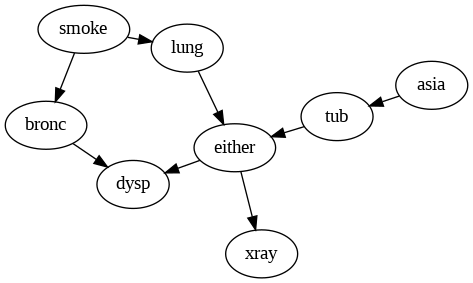

In [ ]:
visualize_graph(g, 'asia')